In [1]:
import pickle
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from yellowbrick.classifier import ConfusionMatrix
from sklearn.model_selection import GridSearchCV, KFold, train_test_split, cross_val_score
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_recall_fscore_support
import numpy as np
import scipy.stats as st
from sklearn.preprocessing import MinMaxScaler

***Open with data***

In [2]:
with open('../DataBases/CD4EncodedBase.pkl', 'rb') as f:
    columns, Cd4AttributesTrainingBalanced, Cd4ClassResultsTrainingBalanced, Cd4AttributesTest, Cd4ClassResultsTest = pickle.load(f)
with open('../Databases/VlEncodedBase.pkl', 'rb') as f:
    columns, VlAttributesTrainingBalanced, VlClassResultsTrainingBalanced, VlAttributesTest, VlClassResultsTest = pickle.load(f)


***Normalize data for MLP***

In [3]:
scaler = MinMaxScaler()

scaler.fit(np.concatenate((Cd4AttributesTrainingBalanced, Cd4AttributesTest), axis=0))
normalized_Cd4AttributesTrainingBalanced = scaler.transform(Cd4AttributesTrainingBalanced)
normalized_Cd4AttributesTest = scaler.transform(Cd4AttributesTest)

scaler.fit(np.concatenate((VlAttributesTrainingBalanced, VlAttributesTest), axis=0))
normalized_VlAttributesTrainingBalanced = scaler.transform(VlAttributesTrainingBalanced)
normalized_VlAttributesTest = scaler.transform(VlAttributesTest)

***GridSearch for MLP***

In [4]:
params = {
    'hidden_layer_sizes': [(100,), (50, 50), (30, 30, 30), (150,), (50,)],
    'activation': ['relu', 'tanh', 'logistic', 'identity'],
    'alpha': [0.0001, 0.001, 0.01],
}

***Creating Grid***

In [5]:
grid = GridSearchCV(
    MLPClassifier(random_state=42),
    param_grid=params,
    cv=5,
    verbose=1,
    n_jobs=-1,
    scoring='accuracy'
)

***Run Grid***

In [6]:
grid.fit(normalized_Cd4AttributesTrainingBalanced, Cd4ClassResultsTrainingBalanced)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


GridSearchCV(cv=5, estimator=MLPClassifier(random_state=42), n_jobs=-1,
             param_grid={'activation': ['relu', 'tanh', 'logistic', 'identity'],
                         'alpha': [0.0001, 0.001, 0.01],
                         'hidden_layer_sizes': [(100,), (50, 50), (30, 30, 30),
                                                (150,), (50,)]},
             scoring='accuracy', verbose=1)

In [7]:
print(grid.best_params_)
print(grid.best_score_)
best_model = grid.best_estimator_
best_params = grid.best_params_

{'activation': 'relu', 'alpha': 0.001, 'hidden_layer_sizes': (150,)}
0.7446643733098998


***k-fold***

In [8]:
import numpy as np
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from copy import deepcopy

kf = KFold(n_splits=15, shuffle=True, random_state=42)
best_accuracy = 0
best_model_kfold = None

# Create an empty list to store the metrics from each fold
accuracy = []
precision_scores_class_0 = []
precision_scores_class_1 = []
recall_scores_class_0 = []
recall_scores_class_1 = []
f1_scores_class_0 = []
f1_scores_class_1 = []
fold = 0

# Perform k-fold cross-validation
for train_index, val_index in kf.split(VlAttributesTrainingBalanced):
    X_train, X_val = normalized_Cd4AttributesTrainingBalanced[train_index], normalized_Cd4AttributesTrainingBalanced[val_index]
    y_train, y_val = Cd4ClassResultsTrainingBalanced[train_index], Cd4ClassResultsTrainingBalanced[val_index]

    # Fit the model on the training data
    best_model.fit(X_train, y_train)

    # Predict the labels for the validation data
    y_pred = best_model.predict(X_val)

    # Store the precision, recall, and F-measure scores for each class
    precision, recall, fscore, support = precision_recall_fscore_support(y_val, y_pred, average=None)
    accuracy.append(accuracy_score(y_val, y_pred))
    precision_scores_class_0.append(precision[0])
    precision_scores_class_1.append(precision[1])
    recall_scores_class_0.append(recall[0])
    recall_scores_class_1.append(recall[1])
    f1_scores_class_0.append(fscore[0])
    f1_scores_class_1.append(fscore[1])

    # Update the best model if a better accuracy is found
    fold_accuracy = accuracy_score(y_val, y_pred)
    if fold_accuracy > best_accuracy:
        best_accuracy = fold_accuracy
        best_model_kfold = deepcopy(best_model)

    fold += 1

precision_avg_class_0 = np.round(np.mean(precision_scores_class_0), 3)
precision_avg_class_1 = np.round(np.mean(precision_scores_class_1), 3)
recall_avg_class_0 = np.round(np.mean(recall_scores_class_0), 3)
recall_avg_class_1 = np.round(np.mean(recall_scores_class_1), 3)
f1_avg_class_0 = np.round(np.mean(f1_scores_class_0), 3)
f1_avg_class_1 = np.round(np.mean(f1_scores_class_1), 3)
accuracy_avg = np.round(np.mean(accuracy), 3)

print("Average Precision - Class 0:", precision_avg_class_0)
print("Average Precision - Class 1:", precision_avg_class_1)
print("---------------------------------------------------")
print("Average Recall - Class 0:", recall_avg_class_0)
print("Average Recall - Class 1:", recall_avg_class_1)
print("---------------------------------------------------")
print("Average F1 Score - Class 0:", f1_avg_class_0)
print("Average F1 Score - Class 1:", f1_avg_class_1)
print("---------------------------------------------------")
print("Average Accuracy:", accuracy_avg)
print("Best Model Accuracy:", best_accuracy)

with open('../Results/Cd4Mlp.pkl', 'wb') as f:
    pickle.dump([accuracy], f)


c:\Users\gusta\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\gusta\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\gusta\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\gusta\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the opti

Average Precision - Class 0: 0.67
Average Precision - Class 1: 0.74
---------------------------------------------------
Average Recall - Class 0: 0.621
Average Recall - Class 1: 0.78
---------------------------------------------------
Average F1 Score - Class 0: 0.643
Average F1 Score - Class 1: 0.759
---------------------------------------------------
Average Accuracy: 0.714
Best Model Accuracy: 0.7518796992481203


c:\Users\gusta\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


***confidence interval***

In [9]:
#Function for calculating confidence interval from cross-validation
def interval_confidence(values):
    return st.t.interval(confidence=0.95, df=len(values)-1, loc=np.mean(values), scale=st.sem(values))
    
# Calculate confidence intervals for precision, recall, and F1 scores of each class
precision_ci_class_0 = interval_confidence(np.array(precision_scores_class_0))
precision_ci_class_1 = interval_confidence(np.array(precision_scores_class_1))
recall_ci_class_0 = interval_confidence(np.array(recall_scores_class_0))
recall_ci_class_1 = interval_confidence(np.array(recall_scores_class_1))
fscore_ci_class_0 = interval_confidence(np.array(f1_scores_class_0))
fscore_ci_class_1 = interval_confidence(np.array(f1_scores_class_1))
accuracy_ci = interval_confidence(np.array(accuracy))

# Print confidence intervals for each class
print("95% Confidence Interval - Precision - Class 0:")
print(precision_ci_class_0)
print("---------------------------------------------------")
print("95% Confidence Interval - Precision - Class 1:")
print(precision_ci_class_1)
print("---------------------------------------------------")
print("95% Confidence Interval - Recall - Class 0:")
print(recall_ci_class_0)
print("---------------------------------------------------")
print("95% Confidence Interval - Recall - Class 1:")
print(recall_ci_class_1)
print("---------------------------------------------------")
print("95% Confidence Interval - F1 Score - Class 0:")
print(fscore_ci_class_0)
print("---------------------------------------------------")
print("95% Confidence Interval - F1 Score - Class 1:")
print(fscore_ci_class_1)
print("---------------------------------------------------")
print("95% Confidence Interval - Accuracy:")
print(accuracy_ci)


95% Confidence Interval - Precision - Class 0:
(0.6411594153334768, 0.6996210606088304)
---------------------------------------------------
95% Confidence Interval - Precision - Class 1:
(0.7191278201998227, 0.7612097325225927)
---------------------------------------------------
95% Confidence Interval - Recall - Class 0:
(0.5888150521002944, 0.6525458606172103)
---------------------------------------------------
95% Confidence Interval - Recall - Class 1:
(0.7613313216520508, 0.7980836841491294)
---------------------------------------------------
95% Confidence Interval - F1 Score - Class 0:
(0.6170783660827979, 0.6697885769445624)
---------------------------------------------------
95% Confidence Interval - F1 Score - Class 1:
(0.7432521340609036, 0.7743395720272414)
---------------------------------------------------
95% Confidence Interval - Accuracy:
(0.6980157603811735, 0.7292618676511716)


***Criando e executando a MLP***

In [10]:
mlp = best_model
model = mlp.fit(normalized_Cd4AttributesTrainingBalanced, Cd4ClassResultsTrainingBalanced)
model.score(normalized_Cd4AttributesTest, Cd4ClassResultsTest)

0.7230193387398628

***Analisando métricas da Random Forest criada***

              precision    recall  f1-score   support

           0       0.67      0.66      0.66       667
           1       0.76      0.77      0.76       936

    accuracy                           0.72      1603
   macro avg       0.71      0.71      0.71      1603
weighted avg       0.72      0.72      0.72      1603



c:\Users\gusta\AppData\Local\Programs\Python\Python310\lib\site-packages\yellowbrick\classifier\base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  warnings.warn(


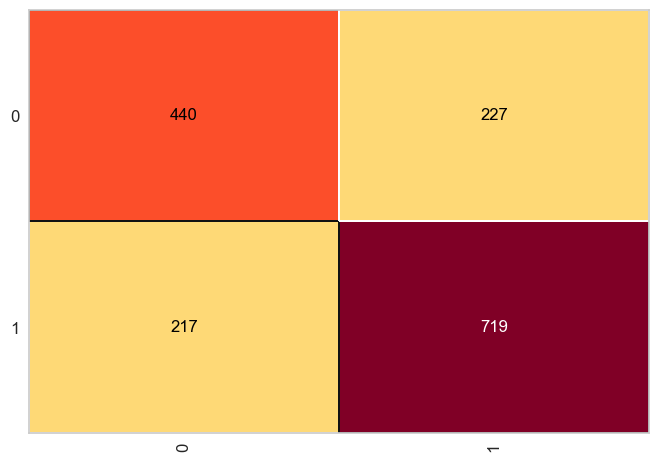

In [11]:
from sklearn.metrics import confusion_matrix

cm = ConfusionMatrix(model)
cm.score(normalized_Cd4AttributesTest, Cd4ClassResultsTest)
y_pred = model.predict(normalized_Cd4AttributesTest)
report = classification_report(Cd4ClassResultsTest, y_pred)
print(report)